In [1]:
import json
from tqdm import tqdm
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp

from s4hci.utils.data_handling import load_adi_data
from s4hci.models.noise import S4Noise
from s4hci.models.planet import S4Planet
from s4hci.utils.adi_tools import combine_residual_stack
from s4hci.utils.masks import construct_round_rfrr_template

from applefy.utils.fake_planets import add_fake_planets
from applefy.utils.file_handling import save_as_fits

## Load the data

In [2]:
print("Loading data ... ", end='')
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data("/fast/mbonse/s4/30_data/EpsEri_0100_C-0656-A.hdf5",
                  data_tag="13_object_final",
                  psf_template_tag="10_psf",
                  para_tag="header_13_object_final/PARANG") 

psf_template_data = np.mean(raw_psf_template_data, axis=0)
print("[DONE]")

Loading data ... [DONE]


## Add a fake planet

In [3]:
config_file = "/fast/mbonse/s4/30_data/0100_C-0656-A/configs_cgrid/exp_ID_0117a.json"

In [4]:
with open(config_file) as json_file:
    fake_planet_config = json.load(json_file)

In [5]:
fake_planet_config

{'type': 'TP estimation',
 'flux_ratio': 0.00039810717055349735,
 'separation': 6.300000000000001,
 'planet_position': [59.3, 53.0, 6.300000000000001, 0.0],
 'exp_id': '0117a'}

In [6]:
# prepare the psf_template
template_cut, _ = construct_round_rfrr_template(
    radius=4.0,
    psf_template_in=psf_template_data)

In [7]:
data_with_fake_planet = add_fake_planets(
    input_stack=science_data,
    psf_template=template_cut, #psf_template_data,
    parang=raw_angles,
    dit_psf_template=0.004256,
    dit_science=0.08,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

In [8]:
# This noise model was only trained on half of the images
X_train = data_with_fake_planet[0::2]
anlges_train = raw_angles[0::2]
X_test = data_with_fake_planet[1::2]
anlges_test = raw_angles[1::2]

In [9]:
anlges_test.shape

(34665,)

## Load a pre-trained noise model

In [ ]:
save_path_final = Path("/fast/mbonse/s4/70_results/02_fine_tuning/implementation_tests/test_model_trained_fp64.pkl")
s4_noise = S4Noise.load(save_path_final)

## Create one test residual

In [11]:
s4_noise = s4_noise.float()
s4_noise = s4_noise.to(0)

In [12]:
science_data = torch.from_numpy(X_train).float()
science_data = science_data.to(0)

In [13]:
residuals, _ = s4_noise.predict(science_data)

In [14]:
residuals = residuals.cpu().numpy()

In [15]:
residuals -= np.median(residuals, axis=0)

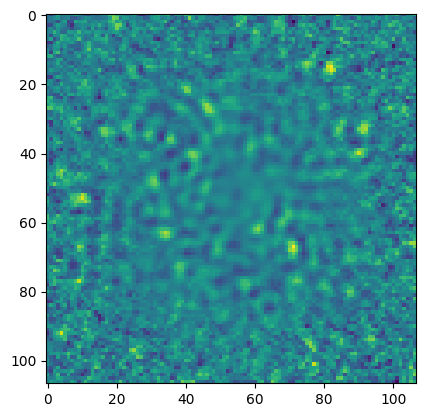

In [16]:
plt.imshow(residuals[17])

In [17]:
results = combine_residual_stack(
    residual_stack=residuals,
    angles=anlges_train,
    combine=["Median_Residuals",],
    suffix="",
    num_cpus=8)

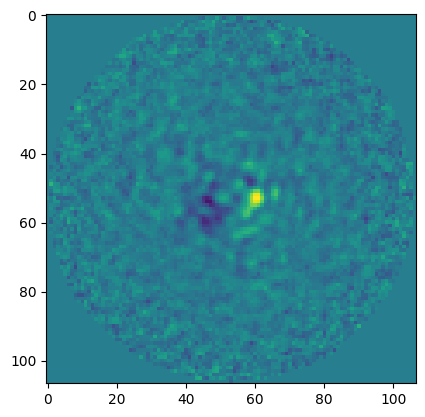

In [18]:
# residual on training data
plt.imshow(results["Median_Residuals"],
           vmin=-0.03, vmax=0.04)

In [19]:
#save_as_fits(results["Median_Residuals"], "residual_117a_no_planet_model.fits")

## Implement the fine-tuning

In [10]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage.transform import rescale

from s4hci.models.rotation import FieldRotationModel
from s4hci.utils.masks import construct_planet_mask


class S4Planet(nn.Module):

    def __init__(
            self,
            data_image_size,
            psf_template,
            # used for the inner radius of the planet mask
            inner_mask_radius=0,
            use_up_sample=1):

        super(S4Planet, self).__init__()

        # 1.) Prepare the PSF template
        psf_model_scaled = rescale(psf_template,
                                   use_up_sample,
                                   preserve_range=True)

        # the psf template is not trainable but also send to the gpu.
        self.register_buffer(
            "psf_model",
            torch.from_numpy(psf_model_scaled).unsqueeze(0).unsqueeze(0).float()
        )

        self.output_size = data_image_size
        self.input_size = int(data_image_size * use_up_sample)
        self.inner_mask_radius = inner_mask_radius

        # 2.) Init the planet model
        # values equal to zero can cause numerical instability
        self.planet_model = nn.Parameter(
            torch.abs(torch.randn(1,
                       self.input_size,
                       self.input_size).float())* 0.00001,
            #torch.ones(1,
            #           self.input_size,
            #           self.input_size).float() * 0.01,
            requires_grad=True)

        # 3.) Set up the planet mask
        planet_mask = construct_planet_mask(
            self.input_size,
            int(inner_mask_radius * use_up_sample))  # inner region mask

        # the mask is not trainable but also send to the gpu.
        self.register_buffer(
            "planet_mask",
            torch.from_numpy(planet_mask).unsqueeze(0).float())

        # 4.) There are several member variables which are set during training.
        # We initialize them here with None
        # 4.1 ) rotation grid for the training data
        self.rotation = None

    def save(self, file_path):
        state_dict = self.state_dict()

        # add the other information we want to keep
        state_dict["use_up_sample"] = self.use_up_sample
        state_dict["output_size"] = self.output_size
        state_dict["inner_mask_radius"] = self.inner_mask_radius

        torch.save(state_dict, file_path)

    @classmethod
    def load(cls, file_path):
        state_dict = torch.load(file_path)

        # create a dummy psf template
        psf_size = state_dict["psf_model"].shape[-1]
        dummy_template = np.ones((psf_size, psf_size))

        obj = cls(
            data_image_size=state_dict.pop('output_size'),
            psf_template=dummy_template,
            inner_mask_radius=state_dict.pop('inner_mask_radius'),
            use_up_sample=state_dict.pop('use_up_sample'))

        obj.load_state_dict(state_dict)

        return obj

    def setup_for_training(
            self,
            all_angles,
            rotation_grid_down_sample,
            upload_rotation_grid=False):

        # Build the rotation grid for the training data
        # we have to rotate into the opposite direction
        self.rotation = FieldRotationModel(
            all_angles,
            input_size=self.input_size,
            inverse=True,
            subsample=rotation_grid_down_sample,
            register_grid=upload_rotation_grid)

    @property
    def planet_parameters(self):
        return self.planet_model **2

    def get_planet_signal(self):
        planet_signal = F.conv2d(
            self.planet_parameters.unsqueeze(0),
            self.psf_model,
            padding="same")

        # mask circular pattern
        masked_planet_signal = planet_signal.squeeze(0) * self.planet_mask
        
        # masked_planet_signal - torch.median(masked_planet_signal)
        return masked_planet_signal

    def forward(self,
                parang_idx=None,
                new_angles=None):

        if new_angles is not None:
            num_copies = len(new_angles)
        else:
            num_copies = len(parang_idx)

        # 1.) Get the current planet signal and repeat it
        raw_planet_signal = self.get_planet_signal()

        # create stack of planet frames
        planet_stack = raw_planet_signal.repeat(num_copies, 1, 1).clone()

        # 2.) Rotate the planet frames
        output_dim = (self.output_size,
                      self.output_size)

        planet_stack = self.rotation(
            planet_stack.unsqueeze(1),
            parang_idx=parang_idx,
            new_angles=new_angles,
            output_dimensions=output_dim)

        return planet_stack


In [47]:
science_train_torch = torch.from_numpy(X_train).float().to(0) # X
anlges_train = anlges_train

## Test how P and n(P) look like

In [48]:
import torch
from torch import nn
from torch import optim

In [79]:
# prepare the psf_template
template_cut, _ = construct_round_rfrr_template(
    radius=4.0,
    psf_template_in=psf_template_data)

template_norm = template_cut# / np.max(np.abs(template_cut))

In [80]:
# Create a planet model
s4_planet_model = S4Planet(
    data_image_size=X_train.shape[-1],
    psf_template=template_norm,
    inner_mask_radius=0,
    use_up_sample=1)

In [81]:
# setup planet model for training
s4_planet_model.setup_for_training(
    all_angles=anlges_train,
    rotation_grid_down_sample=10,
    upload_rotation_grid=True)

In [82]:
s4_planet_model = s4_planet_model.to(0)
test_idx = torch.from_numpy(np.arange(science_train_torch.shape[0]))
s4_noise.betas_raw.requires_grad = False

In [83]:
test_idx

tensor([    0,     1,     2,  ..., 34663, 34664, 34665])

In [84]:
optimizer = optim.Adam(
    [#s4_noise.betas_raw,
     s4_planet_model.planet_model,],
    lr=1e-3)#,  # 1e-1
#    momentum=0.9)

## Run the fine-tuning

### Create a second noise model for the planet

In [85]:
save_path_final = Path("/fast/mbonse/s4/70_results/02_fine_tuning/implementation_tests/test_model_trained_fp64.pkl")
s4_noise_planet = S4Noise.load(save_path_final)

s4_noise_planet = s4_noise_planet.float()
s4_noise_planet = s4_noise_planet.to(0)

Creating right reason mask ... [DONE]


In [86]:
s4_noise_planet.betas_raw.requires_grad = False

### Run the actual fine-tuning

In [87]:
# Normalize the data
science_norm = s4_noise.normalize_data(science_train_torch)

# reshape the science data
science_norm_flatten = science_norm.view(
    science_norm.shape[0], -1)

# compute the noise estimate
# 1.) Compute Beta
s4_noise.compute_betas()

with torch.no_grad():
    noise_estimate = s4_noise(science_norm_flatten)

In [88]:
optimizer = optim.Adam(
    [#s4_noise.betas_raw,
     s4_planet_model.planet_model,],
    lr=1e-3)#,  # 1e-1
#    momentum=0.9)

  0%|▌                                                                                                                       | 1/200 [00:01<03:45,  1.13s/it]

0.34535911679267883


  1%|█▏                                                                                                                      | 2/200 [00:02<03:41,  1.12s/it]

0.34535834193229675


  2%|█▊                                                                                                                      | 3/200 [00:03<03:39,  1.11s/it]

0.34535810351371765


  2%|██▍                                                                                                                     | 4/200 [00:04<03:37,  1.11s/it]

0.3453580141067505


  2%|███                                                                                                                     | 5/200 [00:05<03:36,  1.11s/it]

0.34535765647888184


  3%|███▌                                                                                                                    | 6/200 [00:06<03:34,  1.11s/it]

0.3453569710254669


  4%|████▏                                                                                                                   | 7/200 [00:07<03:33,  1.11s/it]

0.345356285572052


  4%|████▊                                                                                                                   | 8/200 [00:08<03:32,  1.11s/it]

0.345355749130249


  4%|█████▍                                                                                                                  | 9/200 [00:09<03:31,  1.11s/it]

0.3453555107116699
0.345355361700058


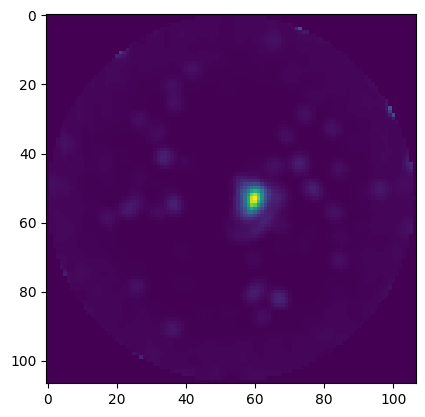

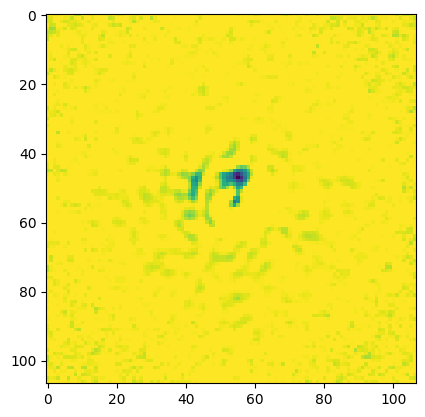

  6%|██████▌                                                                                                                | 11/200 [00:13<04:04,  1.29s/it]

0.34535524249076843


  6%|███████▏                                                                                                               | 12/200 [00:14<03:52,  1.24s/it]

0.3453550636768341


  6%|███████▋                                                                                                               | 13/200 [00:15<03:43,  1.20s/it]

0.34535491466522217


  7%|████████▎                                                                                                              | 14/200 [00:16<03:37,  1.17s/it]

0.34535470604896545


  8%|████████▉                                                                                                              | 15/200 [00:17<03:33,  1.15s/it]

0.3453545570373535


  8%|█████████▌                                                                                                             | 16/200 [00:18<03:29,  1.14s/it]

0.34535443782806396


  8%|██████████                                                                                                             | 17/200 [00:19<03:26,  1.13s/it]

0.3453543186187744


  9%|██████████▋                                                                                                            | 18/200 [00:20<03:24,  1.12s/it]

0.34535422921180725


 10%|███████████▎                                                                                                           | 19/200 [00:21<03:22,  1.12s/it]

0.3453541100025177
0.34535399079322815


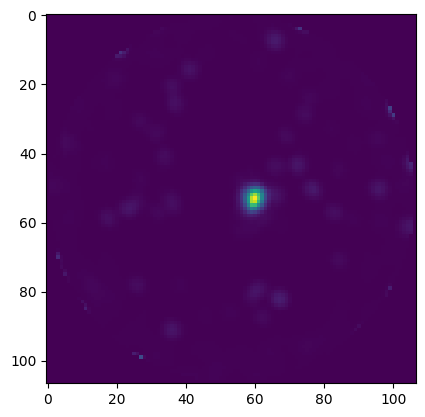

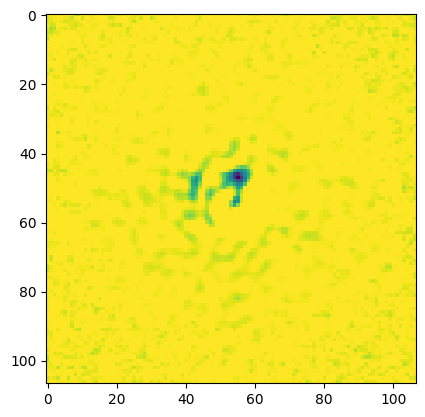

 10%|████████████▍                                                                                                          | 21/200 [00:24<03:51,  1.29s/it]

0.345353901386261


 11%|█████████████                                                                                                          | 22/200 [00:26<03:39,  1.24s/it]

0.3453538417816162


 12%|█████████████▋                                                                                                         | 23/200 [00:27<03:32,  1.20s/it]

0.34535375237464905


 12%|██████████████▎                                                                                                        | 24/200 [00:28<03:25,  1.17s/it]

0.3453536629676819


 12%|██████████████▉                                                                                                        | 25/200 [00:29<03:21,  1.15s/it]

0.3453535735607147
0.3453535735607147


 14%|████████████████                                                                                                       | 27/200 [00:31<03:15,  1.13s/it]

0.34535351395606995


 14%|████████████████▋                                                                                                      | 28/200 [00:32<03:14,  1.13s/it]

0.3453534245491028


 14%|█████████████████▎                                                                                                     | 29/200 [00:33<03:11,  1.12s/it]

0.3453534245491028
0.3453533351421356


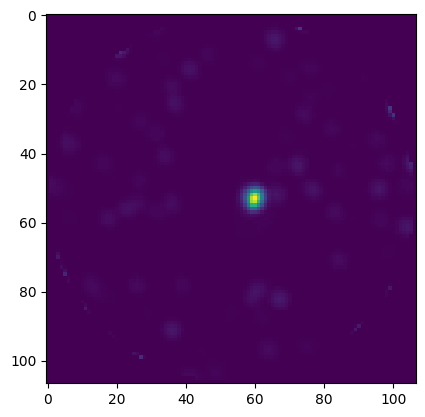

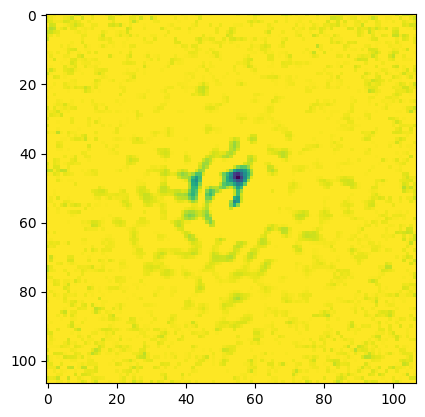

 16%|██████████████████▍                                                                                                    | 31/200 [00:36<03:38,  1.29s/it]

0.3453533351421356
0.34535330533981323


 16%|███████████████████▋                                                                                                   | 33/200 [00:39<03:20,  1.20s/it]

0.34535327553749084


 17%|████████████████████▏                                                                                                  | 34/200 [00:40<03:14,  1.17s/it]

0.34535327553749084


 18%|████████████████████▊                                                                                                  | 35/200 [00:41<03:10,  1.15s/it]

0.34535321593284607


 18%|█████████████████████▍                                                                                                 | 36/200 [00:42<03:06,  1.14s/it]

0.3453531861305237


 18%|██████████████████████                                                                                                 | 37/200 [00:43<03:03,  1.13s/it]

0.3453531861305237


 19%|██████████████████████▌                                                                                                | 38/200 [00:44<03:01,  1.12s/it]

0.3453531563282013


 20%|███████████████████████▏                                                                                               | 39/200 [00:45<02:59,  1.12s/it]

0.3453530967235565
0.3453530967235565


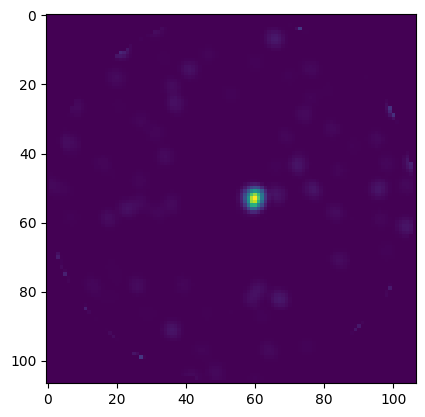

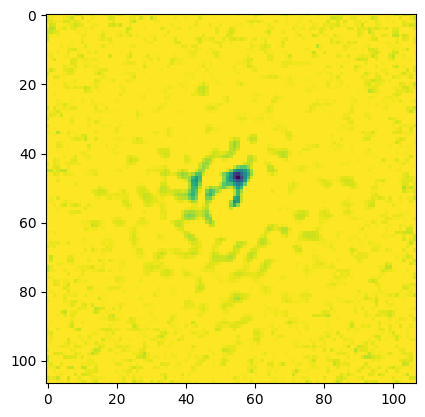

 20%|████████████████████████▍                                                                                              | 41/200 [00:48<03:25,  1.29s/it]

0.3453530967235565


 21%|████████████████████████▉                                                                                              | 42/200 [00:49<03:15,  1.24s/it]

0.34535306692123413


 22%|█████████████████████████▌                                                                                             | 43/200 [00:51<03:08,  1.20s/it]

0.34535306692123413


 22%|██████████████████████████▏                                                                                            | 44/200 [00:52<03:03,  1.17s/it]

0.34535300731658936


 22%|██████████████████████████▊                                                                                            | 45/200 [00:53<02:58,  1.15s/it]

0.34535300731658936
0.34535300731658936


 24%|███████████████████████████▉                                                                                           | 47/200 [00:55<02:52,  1.13s/it]

0.34535300731658936


 24%|████████████████████████████▌                                                                                          | 48/200 [00:56<02:50,  1.12s/it]

0.34535300731658936


 24%|█████████████████████████████▏                                                                                         | 49/200 [00:57<02:48,  1.12s/it]

0.34535300731658936
0.34535297751426697


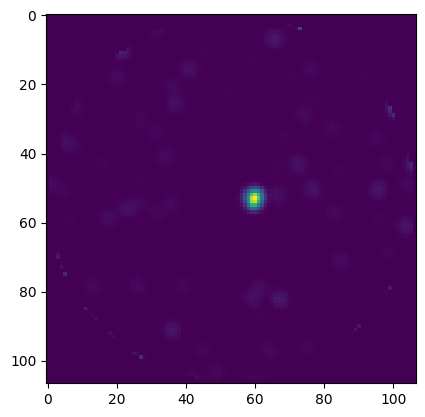

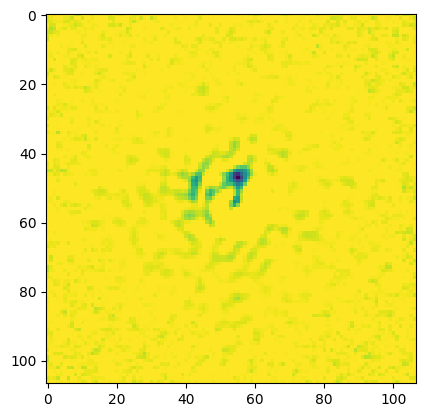

 26%|██████████████████████████████▎                                                                                        | 51/200 [01:00<03:12,  1.29s/it]

0.3453529477119446


 26%|██████████████████████████████▉                                                                                        | 52/200 [01:01<03:03,  1.24s/it]

0.3453529477119446


 26%|███████████████████████████████▌                                                                                       | 53/200 [01:03<02:56,  1.20s/it]

0.3453529477119446


 27%|████████████████████████████████▏                                                                                      | 54/200 [01:04<02:50,  1.17s/it]

0.3453529477119446


 28%|████████████████████████████████▋                                                                                      | 55/200 [01:05<02:46,  1.15s/it]

0.3453529477119446


 28%|█████████████████████████████████▎                                                                                     | 56/200 [01:06<02:43,  1.14s/it]

0.3453529477119446


 28%|█████████████████████████████████▉                                                                                     | 57/200 [01:07<02:41,  1.13s/it]

0.3453529477119446


 29%|██████████████████████████████████▌                                                                                    | 58/200 [01:08<02:39,  1.12s/it]

0.3453529477119446


 30%|███████████████████████████████████                                                                                    | 59/200 [01:09<02:37,  1.12s/it]

0.3453529477119446
0.3453529477119446


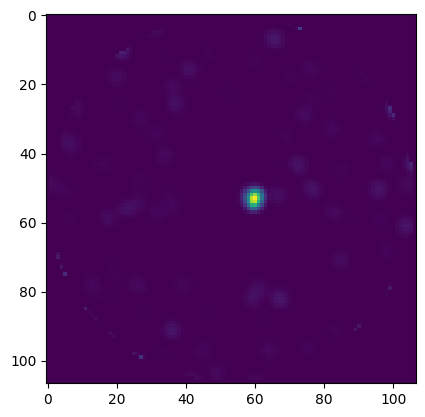

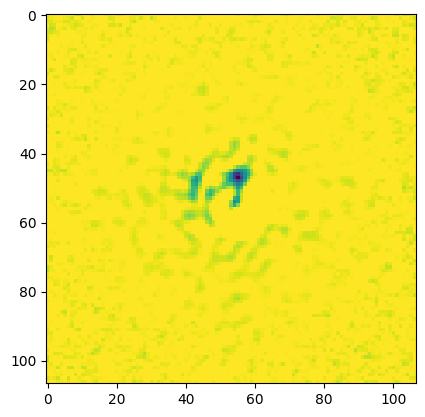

 30%|████████████████████████████████████▎                                                                                  | 61/200 [01:12<02:59,  1.29s/it]

0.3453528881072998


 31%|████████████████████████████████████▉                                                                                  | 62/200 [01:13<02:50,  1.24s/it]

0.3453529477119446


 32%|█████████████████████████████████████▍                                                                                 | 63/200 [01:14<02:44,  1.20s/it]

0.3453528881072998


 32%|██████████████████████████████████████                                                                                 | 64/200 [01:16<02:39,  1.17s/it]

0.3453528881072998


 32%|██████████████████████████████████████▋                                                                                | 65/200 [01:17<02:35,  1.15s/it]

0.3453528583049774


 33%|███████████████████████████████████████▎                                                                               | 66/200 [01:18<02:32,  1.14s/it]

0.3453528583049774


 34%|███████████████████████████████████████▊                                                                               | 67/200 [01:19<02:30,  1.13s/it]

0.3453528583049774


 34%|████████████████████████████████████████▍                                                                              | 68/200 [01:20<02:28,  1.12s/it]

0.3453528583049774


 34%|█████████████████████████████████████████                                                                              | 69/200 [01:21<02:26,  1.12s/it]

0.3453528583049774
0.3453528583049774


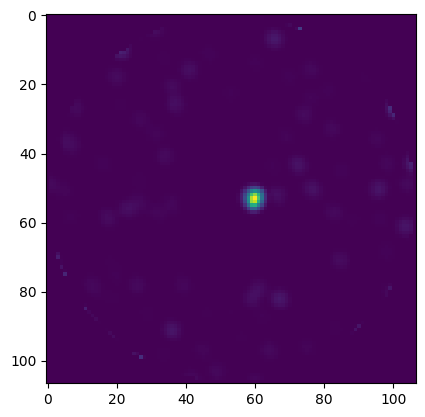

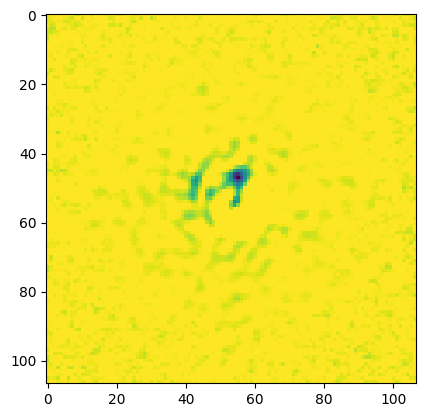

 36%|██████████████████████████████████████████▏                                                                            | 71/200 [01:24<02:46,  1.29s/it]

0.3453528583049774


 36%|██████████████████████████████████████████▊                                                                            | 72/200 [01:25<02:38,  1.24s/it]

0.3453528583049774


 36%|███████████████████████████████████████████▍                                                                           | 73/200 [01:26<02:32,  1.20s/it]

0.3453528583049774


 37%|████████████████████████████████████████████                                                                           | 74/200 [01:27<02:27,  1.17s/it]

0.3453528583049774


 38%|████████████████████████████████████████████▋                                                                          | 75/200 [01:29<02:24,  1.15s/it]

0.3453528583049774


 38%|█████████████████████████████████████████████▏                                                                         | 76/200 [01:30<02:21,  1.14s/it]

0.3453528583049774


 38%|█████████████████████████████████████████████▊                                                                         | 77/200 [01:31<02:19,  1.13s/it]

0.3453528583049774


 39%|██████████████████████████████████████████████▍                                                                        | 78/200 [01:32<02:17,  1.12s/it]

0.3453528583049774


 40%|███████████████████████████████████████████████                                                                        | 79/200 [01:33<02:15,  1.12s/it]

0.3453528583049774
0.3453528583049774


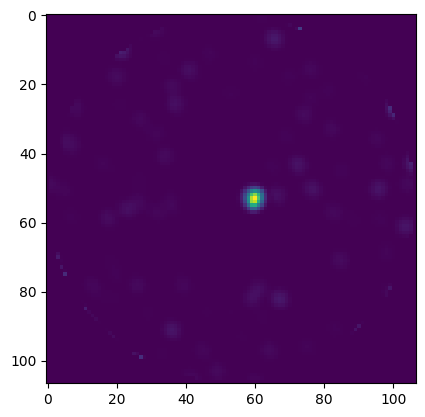

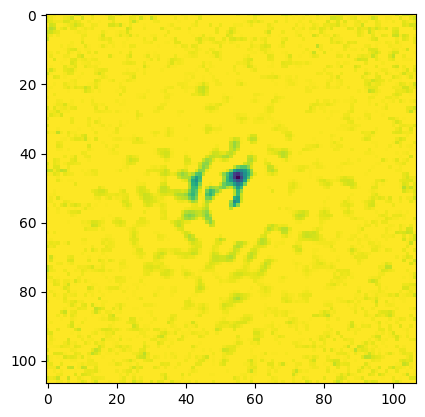

 40%|████████████████████████████████████████████████▏                                                                      | 81/200 [01:36<02:33,  1.29s/it]

0.3453528583049774


 41%|████████████████████████████████████████████████▊                                                                      | 82/200 [01:37<02:25,  1.23s/it]

0.3453528583049774


 42%|█████████████████████████████████████████████████▍                                                                     | 83/200 [01:38<02:19,  1.20s/it]

0.3453528583049774
0.3453528583049774


 42%|██████████████████████████████████████████████████▌                                                                    | 85/200 [01:40<02:12,  1.15s/it]

0.3453528583049774


 43%|███████████████████████████████████████████████████▏                                                                   | 86/200 [01:42<02:09,  1.14s/it]

0.3453528583049774


 44%|███████████████████████████████████████████████████▊                                                                   | 87/200 [01:43<02:07,  1.13s/it]

0.3453528583049774


 44%|████████████████████████████████████████████████████▎                                                                  | 88/200 [01:44<02:05,  1.12s/it]

0.34535282850265503


 44%|████████████████████████████████████████████████████▉                                                                  | 89/200 [01:45<02:03,  1.12s/it]

0.3453528583049774
0.3453528583049774


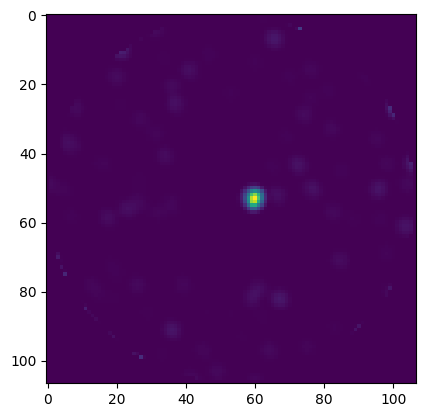

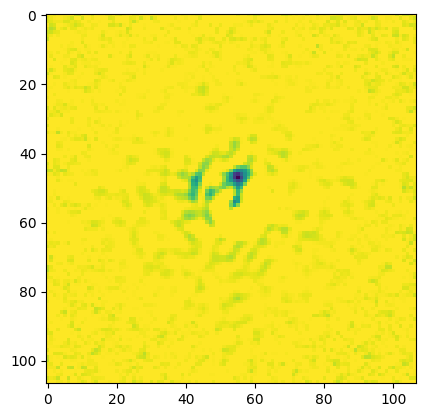

 46%|██████████████████████████████████████████████████████▏                                                                | 91/200 [01:48<02:26,  1.35s/it]

0.3453528583049774


 46%|██████████████████████████████████████████████████████▋                                                                | 92/200 [01:49<02:17,  1.27s/it]

0.34535282850265503


 46%|███████████████████████████████████████████████████████▎                                                               | 93/200 [01:50<02:10,  1.22s/it]

0.3453528583049774


 47%|███████████████████████████████████████████████████████▉                                                               | 94/200 [01:52<02:06,  1.19s/it]

0.34535282850265503


 48%|████████████████████████████████████████████████████████▌                                                              | 95/200 [01:53<02:02,  1.16s/it]

0.34535282850265503


 48%|█████████████████████████████████████████████████████████                                                              | 96/200 [01:54<01:59,  1.15s/it]

0.34535282850265503


 48%|█████████████████████████████████████████████████████████▋                                                             | 97/200 [01:55<01:56,  1.13s/it]

0.34535276889801025


 49%|██████████████████████████████████████████████████████████▎                                                            | 98/200 [01:56<01:54,  1.13s/it]

0.34535282850265503


 50%|██████████████████████████████████████████████████████████▉                                                            | 99/200 [01:57<01:53,  1.12s/it]

0.34535276889801025
0.34535276889801025


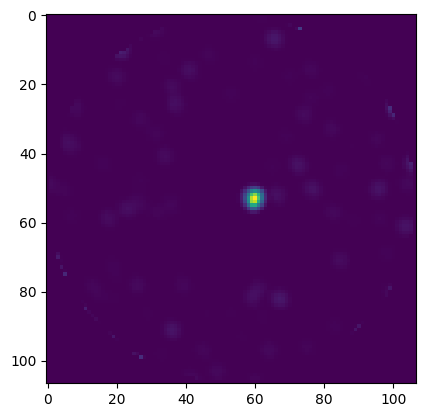

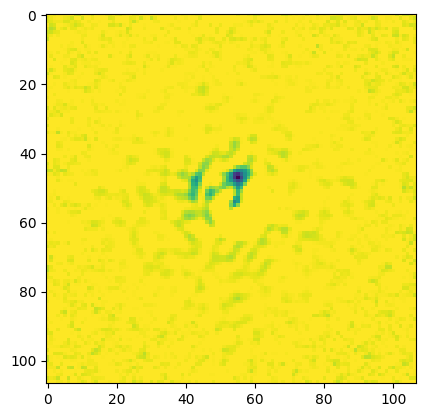

 50%|███████████████████████████████████████████████████████████▌                                                          | 101/200 [02:00<02:07,  1.29s/it]

0.34535276889801025
0.34535276889801025


 52%|████████████████████████████████████████████████████████████▊                                                         | 103/200 [02:02<01:56,  1.20s/it]

0.34535276889801025


 52%|█████████████████████████████████████████████████████████████▎                                                        | 104/200 [02:03<01:52,  1.17s/it]

0.34535276889801025


 52%|█████████████████████████████████████████████████████████████▉                                                        | 105/200 [02:05<01:49,  1.15s/it]

0.34535276889801025


 53%|██████████████████████████████████████████████████████████████▌                                                       | 106/200 [02:06<01:46,  1.14s/it]

0.34535276889801025


 54%|███████████████████████████████████████████████████████████████▏                                                      | 107/200 [02:07<01:44,  1.13s/it]

0.34535282850265503


 54%|███████████████████████████████████████████████████████████████▋                                                      | 108/200 [02:08<01:43,  1.12s/it]

0.34535282850265503
0.34535282850265503


 55%|████████████████████████████████████████████████████████████████▎                                                     | 109/200 [02:09<01:41,  1.12s/it]

0.34535276889801025


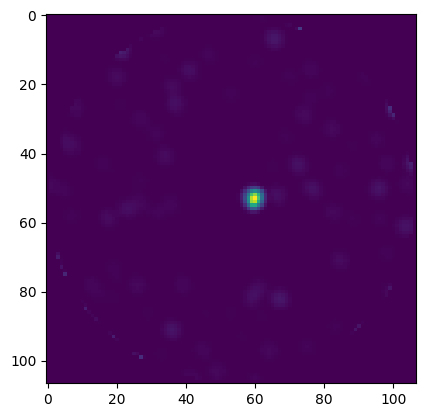

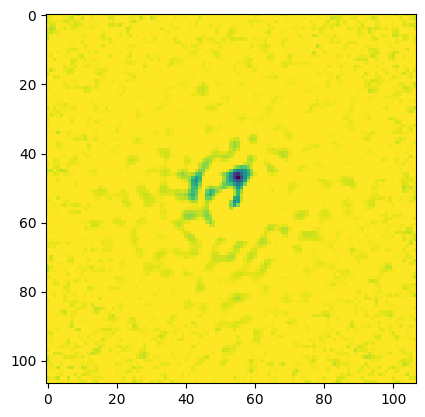

 56%|█████████████████████████████████████████████████████████████████▍                                                    | 111/200 [02:12<01:54,  1.29s/it]

0.34535276889801025


 56%|██████████████████████████████████████████████████████████████████                                                    | 112/200 [02:13<01:48,  1.24s/it]

0.34535276889801025


 56%|██████████████████████████████████████████████████████████████████▋                                                   | 113/200 [02:14<01:44,  1.20s/it]

0.34535276889801025


 57%|███████████████████████████████████████████████████████████████████▎                                                  | 114/200 [02:15<01:40,  1.17s/it]

0.34535276889801025


 57%|███████████████████████████████████████████████████████████████████▊                                                  | 115/200 [02:16<01:37,  1.15s/it]

0.34535276889801025


 58%|████████████████████████████████████████████████████████████████████▍                                                 | 116/200 [02:18<01:35,  1.14s/it]

0.34535276889801025


 58%|█████████████████████████████████████████████████████████████████████                                                 | 117/200 [02:19<01:33,  1.13s/it]

0.34535276889801025


 59%|█████████████████████████████████████████████████████████████████████▌                                                | 118/200 [02:20<01:31,  1.12s/it]

0.34535276889801025


 60%|██████████████████████████████████████████████████████████████████████▏                                               | 119/200 [02:21<01:30,  1.12s/it]

0.34535276889801025
0.34535276889801025


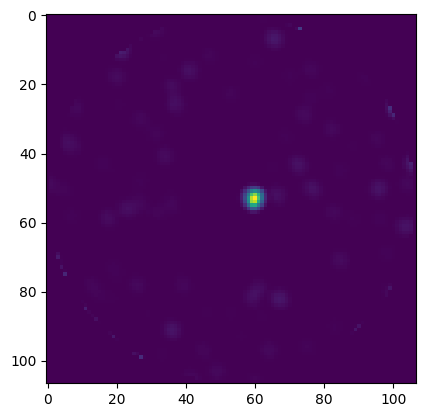

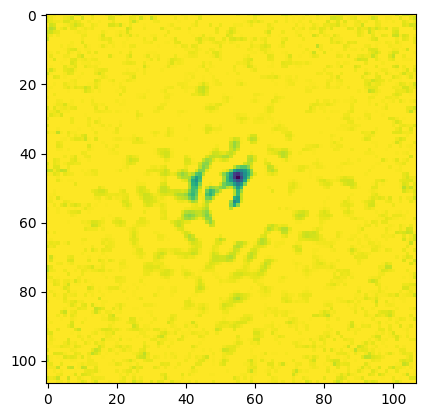

 60%|███████████████████████████████████████████████████████████████████████▍                                              | 121/200 [02:24<01:41,  1.29s/it]

0.34535276889801025


 61%|███████████████████████████████████████████████████████████████████████▉                                              | 122/200 [02:25<01:36,  1.24s/it]

0.34535276889801025


 62%|████████████████████████████████████████████████████████████████████████▌                                             | 123/200 [02:26<01:32,  1.20s/it]

0.34535276889801025


 62%|█████████████████████████████████████████████████████████████████████████▏                                            | 124/200 [02:27<01:29,  1.17s/it]

0.34535276889801025


 62%|█████████████████████████████████████████████████████████████████████████▊                                            | 125/200 [02:28<01:26,  1.16s/it]

0.34535276889801025


 63%|██████████████████████████████████████████████████████████████████████████▎                                           | 126/200 [02:30<01:24,  1.15s/it]

0.34535276889801025


 64%|██████████████████████████████████████████████████████████████████████████▉                                           | 127/200 [02:31<01:22,  1.13s/it]

0.34535276889801025


 64%|███████████████████████████████████████████████████████████████████████████▌                                          | 128/200 [02:32<01:20,  1.12s/it]

0.34535276889801025


 64%|████████████████████████████████████████████████████████████████████████████                                          | 129/200 [02:33<01:19,  1.12s/it]

0.34535276889801025
0.34535276889801025


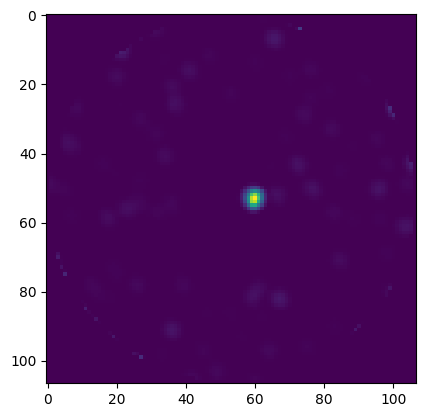

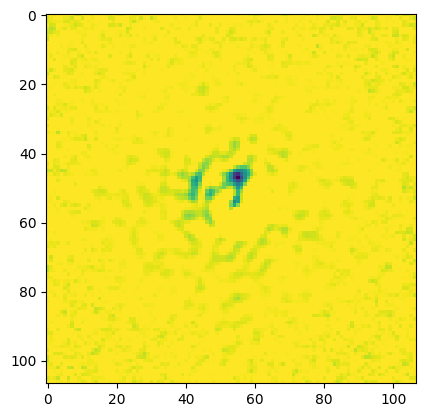

 66%|█████████████████████████████████████████████████████████████████████████████▎                                        | 131/200 [02:36<01:29,  1.29s/it]

0.34535276889801025


 66%|█████████████████████████████████████████████████████████████████████████████▉                                        | 132/200 [02:37<01:24,  1.24s/it]

0.34535276889801025


 66%|██████████████████████████████████████████████████████████████████████████████▍                                       | 133/200 [02:38<01:20,  1.20s/it]

0.34535276889801025
0.34535276889801025


 68%|███████████████████████████████████████████████████████████████████████████████▋                                      | 135/200 [02:40<01:14,  1.15s/it]

0.34535276889801025


 68%|████████████████████████████████████████████████████████████████████████████████▏                                     | 136/200 [02:41<01:12,  1.14s/it]

0.34535276889801025


 68%|████████████████████████████████████████████████████████████████████████████████▊                                     | 137/200 [02:43<01:11,  1.13s/it]

0.34535276889801025


 69%|█████████████████████████████████████████████████████████████████████████████████▍                                    | 138/200 [02:44<01:09,  1.12s/it]

0.34535276889801025


 70%|██████████████████████████████████████████████████████████████████████████████████                                    | 139/200 [02:45<01:08,  1.12s/it]

0.34535276889801025
0.34535276889801025


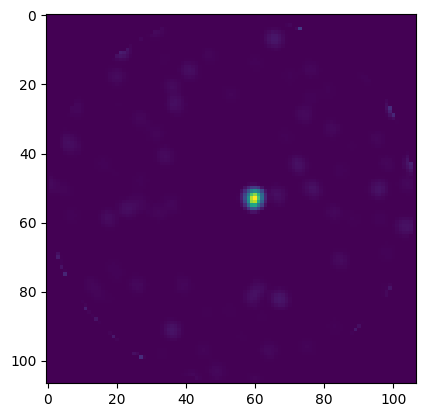

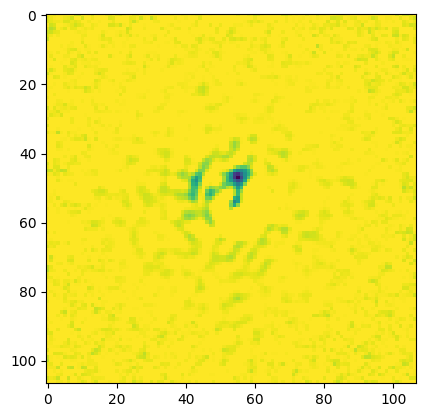

 70%|███████████████████████████████████████████████████████████████████████████████████▏                                  | 141/200 [02:48<01:16,  1.29s/it]

0.34535276889801025


 71%|███████████████████████████████████████████████████████████████████████████████████▊                                  | 142/200 [02:49<01:11,  1.24s/it]

0.34535276889801025


 72%|████████████████████████████████████████████████████████████████████████████████████▎                                 | 143/200 [02:50<01:08,  1.20s/it]

0.34535276889801025


 72%|████████████████████████████████████████████████████████████████████████████████████▉                                 | 144/200 [02:51<01:05,  1.17s/it]

0.34535276889801025


 72%|█████████████████████████████████████████████████████████████████████████████████████▌                                | 145/200 [02:52<01:03,  1.15s/it]

0.34535276889801025


 73%|██████████████████████████████████████████████████████████████████████████████████████▏                               | 146/200 [02:53<01:01,  1.14s/it]

0.34535276889801025


 74%|██████████████████████████████████████████████████████████████████████████████████████▋                               | 147/200 [02:54<00:59,  1.13s/it]

0.34535276889801025


 74%|███████████████████████████████████████████████████████████████████████████████████████▎                              | 148/200 [02:56<00:58,  1.12s/it]

0.34535276889801025


 74%|███████████████████████████████████████████████████████████████████████████████████████▉                              | 149/200 [02:57<00:56,  1.12s/it]

0.34535276889801025
0.34535276889801025


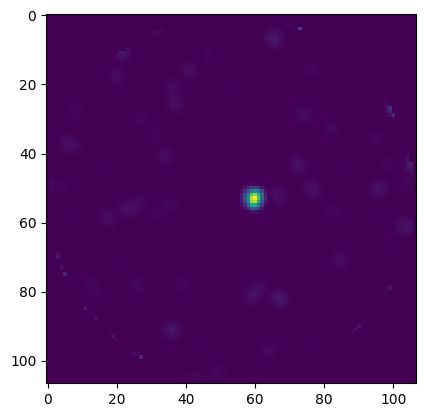

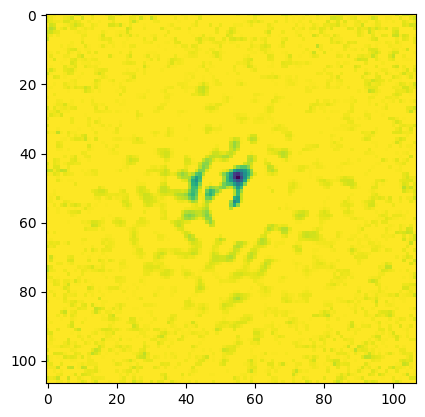

 76%|█████████████████████████████████████████████████████████████████████████████████████████                             | 151/200 [03:00<01:03,  1.29s/it]

0.34535276889801025
0.34535276889801025


 76%|██████████████████████████████████████████████████████████████████████████████████████████▎                           | 153/200 [03:02<00:56,  1.20s/it]

0.34535276889801025


 77%|██████████████████████████████████████████████████████████████████████████████████████████▊                           | 154/200 [03:03<00:53,  1.17s/it]

0.34535276889801025


 78%|███████████████████████████████████████████████████████████████████████████████████████████▍                          | 155/200 [03:04<00:51,  1.15s/it]

0.34535276889801025


 78%|████████████████████████████████████████████████████████████████████████████████████████████                          | 156/200 [03:05<00:50,  1.14s/it]

0.34535276889801025


 78%|████████████████████████████████████████████████████████████████████████████████████████████▋                         | 157/200 [03:06<00:48,  1.13s/it]

0.34535276889801025


 79%|█████████████████████████████████████████████████████████████████████████████████████████████▏                        | 158/200 [03:07<00:47,  1.12s/it]

0.34535276889801025


 80%|█████████████████████████████████████████████████████████████████████████████████████████████▊                        | 159/200 [03:09<00:45,  1.12s/it]

0.34535276889801025
0.34535276889801025


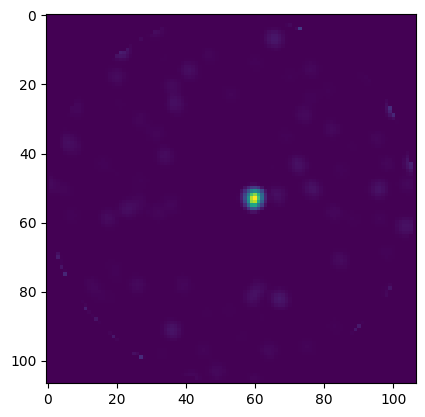

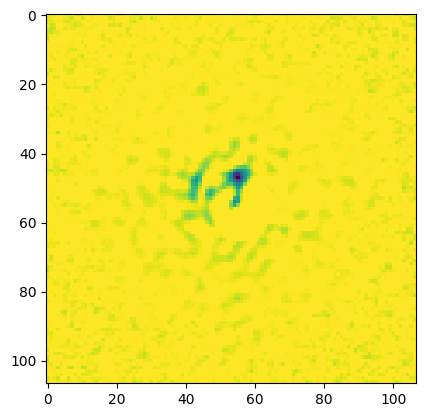

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▉                       | 161/200 [03:12<00:50,  1.29s/it]

0.34535276889801025


 81%|███████████████████████████████████████████████████████████████████████████████████████████████▌                      | 162/200 [03:13<00:47,  1.24s/it]

0.34535276889801025


 82%|████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 163/200 [03:14<00:44,  1.20s/it]

0.34535276889801025


 82%|████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 164/200 [03:15<00:42,  1.17s/it]

0.34535276889801025


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 165/200 [03:16<00:40,  1.15s/it]

0.34535276889801025


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 166/200 [03:17<00:38,  1.14s/it]

0.34535276889801025


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 167/200 [03:18<00:37,  1.13s/it]

0.34535276889801025


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████                   | 168/200 [03:19<00:35,  1.12s/it]

0.34535276889801025


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 169/200 [03:21<00:34,  1.12s/it]

0.34535276889801025
0.34535276889801025


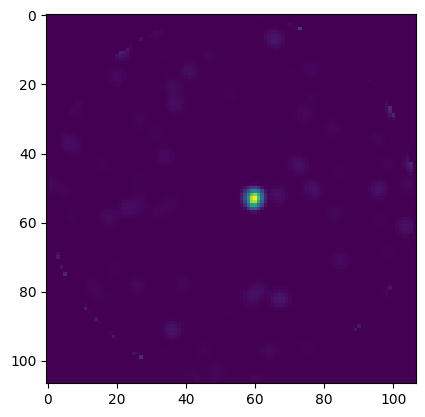

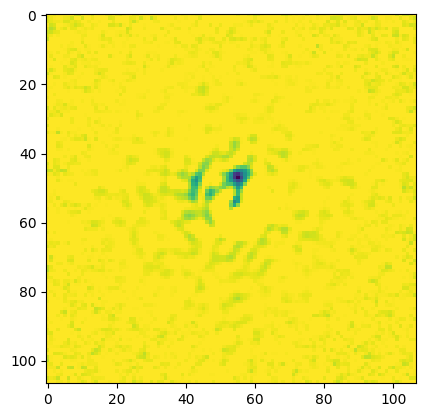

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 171/200 [03:24<00:37,  1.29s/it]

0.34535276889801025


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 172/200 [03:25<00:34,  1.24s/it]

0.34535276889801025


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████                | 173/200 [03:26<00:32,  1.20s/it]

0.34535276889801025


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 174/200 [03:27<00:30,  1.17s/it]

0.34535276889801025


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 175/200 [03:28<00:28,  1.15s/it]

0.34535276889801025


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 176/200 [03:29<00:27,  1.14s/it]

0.34535276889801025


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 177/200 [03:30<00:26,  1.13s/it]

0.34535276889801025


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████             | 178/200 [03:31<00:24,  1.13s/it]

0.34535276889801025


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 179/200 [03:33<00:23,  1.12s/it]

0.34535276889801025
0.34535276889801025


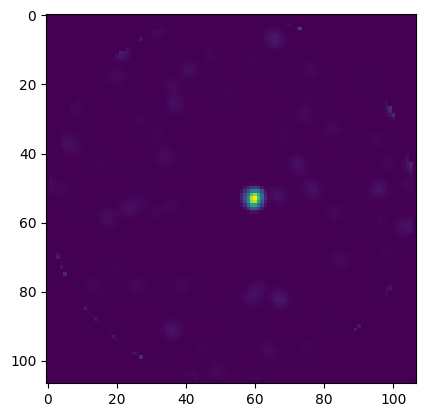

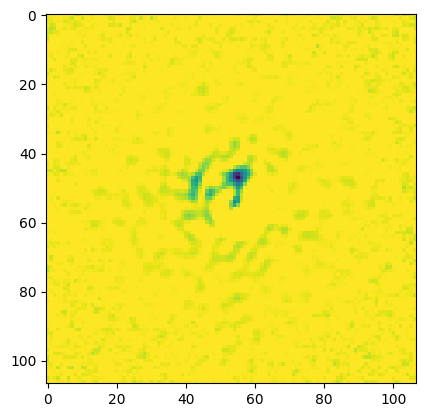

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 181/200 [03:36<00:24,  1.29s/it]

0.34535276889801025
0.34535276889801025


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 183/200 [03:38<00:20,  1.20s/it]

0.34535276889801025


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 184/200 [03:39<00:18,  1.17s/it]

0.34535276889801025


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 185/200 [03:40<00:17,  1.15s/it]

0.34535276889801025


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 186/200 [03:41<00:15,  1.14s/it]

0.34535276889801025


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 187/200 [03:42<00:14,  1.13s/it]

0.34535276889801025


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 188/200 [03:43<00:13,  1.12s/it]

0.34535276889801025


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 189/200 [03:44<00:12,  1.12s/it]

0.34535276889801025
0.34535276889801025


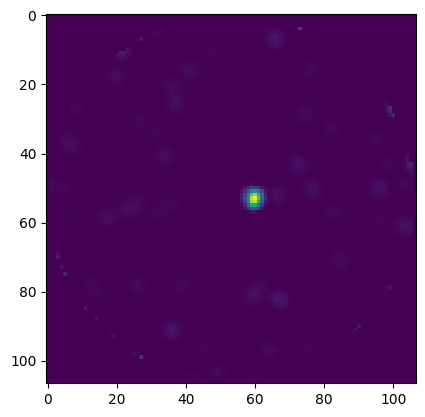

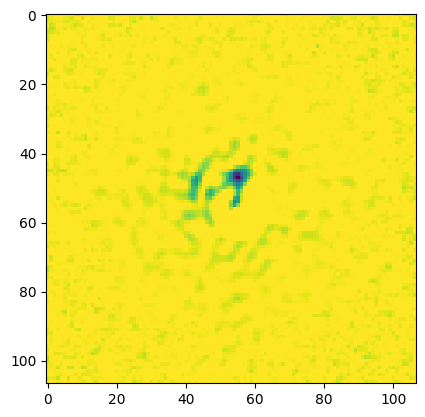

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 191/200 [03:48<00:11,  1.29s/it]

0.34535276889801025


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 192/200 [03:49<00:09,  1.24s/it]

0.34535276889801025


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 193/200 [03:50<00:08,  1.20s/it]

0.34535276889801025


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 194/200 [03:51<00:07,  1.17s/it]

0.34535276889801025


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 195/200 [03:52<00:05,  1.15s/it]

0.34535276889801025


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 196/200 [03:53<00:04,  1.14s/it]

0.34535276889801025


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 197/200 [03:54<00:03,  1.13s/it]

0.34535276889801025


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 198/200 [03:55<00:02,  1.12s/it]

0.34535276889801025


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 199/200 [03:56<00:01,  1.12s/it]

0.34535276889801025
0.34535276889801025


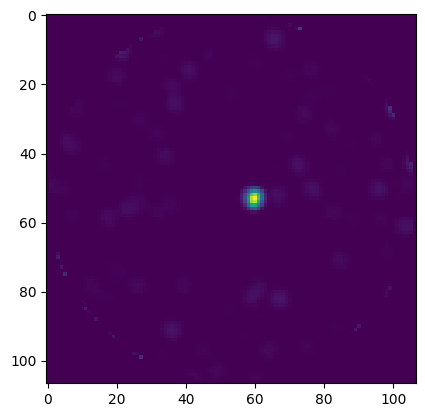

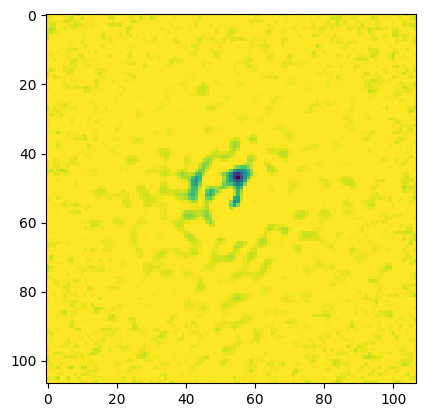

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:58<00:00,  1.19s/it]


In [90]:
losses_recon = []
losses_reg = []

for epoch in tqdm(range(200)):
    optimizer.zero_grad(set_to_none=True)
        
    # 2.) run forward for the planet model
    planet_signal = s4_planet_model.forward(test_idx)
    
    planet_signal = planet_signal + torch.mean(planet_signal, axis=0)
    
    planet_signal_norm = planet_signal / s4_noise.std_frame
    planet_signal_norm = planet_signal_norm.view(science_norm.shape[0], -1)
    
   
    # compute n(P)
    n_p = s4_noise_planet(planet_signal_norm)
    n_p[n_p>0] = 0
    

    # 4.) estimate the modeled data
    modeled_data = noise_estimate + planet_signal_norm - n_p#.detach()
    
    # 4.) Compute the loss       
    loss_recon = ((modeled_data - science_norm_flatten)**2).mean()
    #loss_reg = (s4_noise.betas_raw**2).mean()

    # 5.) Normalize the loss
    loss_normalization = 1.
    loss_recon /= loss_normalization
    #loss_reg /= loss_normalization


    # 6.) Backward 
    loss = loss_recon #+ loss_planet *1e5# + loss_reg * s4_noise.lambda_reg * lambda_factor)
    loss.backward()

    optimizer.step()

    # 7.) Print the loss terms
    losses_recon.append(loss_recon.item())
    #losses_reg.append(loss_reg.item())
    print(loss_recon.item())
    
    if epoch % 10 == 9:
        # plot the planet signal
        with torch.no_grad():
            tmp_norm_signal = s4_planet_model.get_planet_signal() / s4_noise.std_frame
            plt.imshow(tmp_norm_signal.cpu().numpy()[0])
            plt.show()
            
            plt.imshow(n_p.detach().cpu().numpy()[0].reshape(107, 107))
            plt.show()

## Check the terms

In [60]:
# 1.) Compute Beta
s4_noise.compute_betas()

planet_signal = s4_planet_model.forward(test_idx)

planet_signal_norm = planet_signal / s4_noise.std_frame
planet_signal_norm = planet_signal_norm.view(science_norm.shape[0], -1)

# 3.) run forward for the noise
noise_planet = s4_noise_planet(planet_signal_norm)

In [61]:
noise_planet_stack = noise_planet.view(
    science_norm.shape[0], 
    s4_noise.image_size,
    s4_noise.image_size).detach().cpu().numpy()

planet_stack = planet_signal_norm.view(
    science_norm.shape[0], 
    s4_noise.image_size,
    s4_noise.image_size).detach().cpu().numpy()

In [62]:
noise_planet_combined = combine_residual_stack(
    residual_stack=noise_planet_stack,
    angles=anlges_train,
    combine=["Median_Residuals",],
    suffix="",
    num_cpus=8)

planet_combined = combine_residual_stack(
    residual_stack=planet_stack,
    angles=anlges_train,
    combine=["Median_Residuals",],
    suffix="",
    num_cpus=8)

In [63]:
#save_as_fits(planet_combined["Median_Residuals"], "planet_model_117a_no_loss.fits")
#save_as_fits(noise_planet_combined["Median_Residuals"], "noise_planet_model_117a_no_loss.fits")

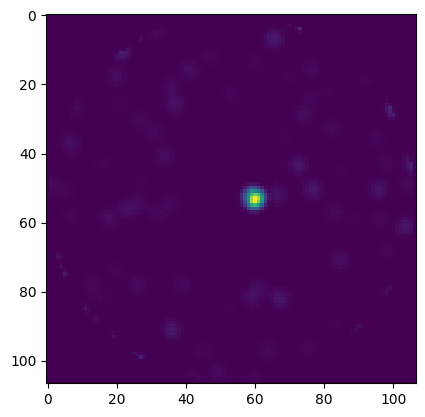

In [64]:
# residual on training data
plt.imshow(planet_combined["Median_Residuals"])

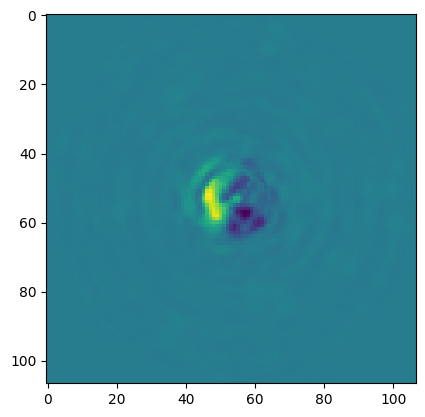

In [65]:
# residual on training data
test_image = noise_planet_combined["Median_Residuals"]
plt.imshow(test_image)

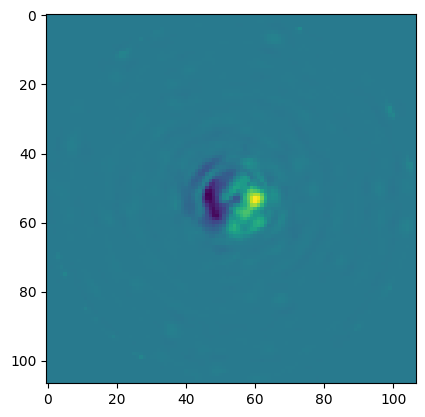

In [66]:
# residual on training data
plt.imshow(planet_combined["Median_Residuals"] - noise_planet_combined["Median_Residuals"])

In [73]:
# 1.) Compute Beta
s4_noise.compute_betas()

planet_signal = s4_planet_model.forward(test_idx)

#planet_signal = planet_signal - torch.mean(planet_signal, axis=0)

planet_signal_norm = planet_signal / s4_noise.std_frame
planet_signal_norm = planet_signal_norm.view(science_norm.shape[0], -1)

if True:
    tmp_science_in = science_norm_flatten - planet_signal_norm
else:
    tmp_science_in = science_norm_flatten


# 3.) run forward for the noise
noise_estimate = s4_noise(tmp_science_in)

In [74]:
# compute the residual
residuals = science_norm_flatten - noise_estimate
residual_stack = residuals.view(
    science_norm.shape[0], 
    s4_noise.image_size,
    s4_noise.image_size).detach().cpu().numpy()

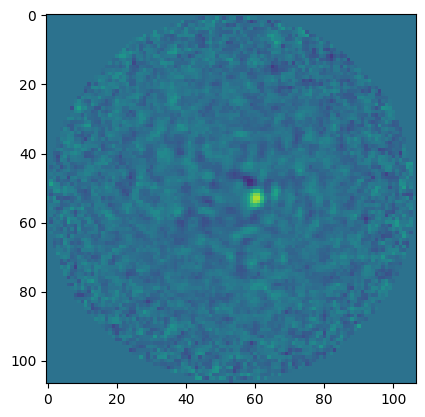

In [75]:
residual_stack -= np.median(residual_stack, axis=0)

results = combine_residual_stack(
    residual_stack=residual_stack,
    angles=anlges_train,
    combine=["Median_Residuals",],
    suffix="",
    num_cpus=8)

# residual on training data
plt.imshow(results["Median_Residuals"],
           vmin=-0.03, vmax=0.05)

In [76]:
save_as_fits(results["Median_Residuals"], "residual_117a_with_planet_no_loss_median_mean_planet_sub.fits")

# B) Implement the fine-tuning loop which considers normalization

In [104]:
# load the noise model
save_path_final = Path(
    "/fast/mbonse/s4/70_results/02_fine_tuning/implementation_tests/test_model_trained_fp64.pkl")
s4_noise = S4Noise.load(save_path_final)

Creating right reason mask ... [DONE]


In [105]:
# reduce complexity of noise model
s4_noise = s4_noise.float()
s4_noise = s4_noise.to(0)

s4_noise.betas_raw.requires_grad = False

In [106]:
# transfer the data to pytorch
science_data_X = torch.from_numpy(X_train).float()
science_data_X = science_data_X.to(0)

In [107]:
# create the planet model

# prepare the psf_template
template_cut, _ = construct_round_rfrr_template(
    radius=4.0,
    psf_template_in=psf_template_data)

template_norm = template_cut

# Create a planet model
s4_planet_model = S4Planet(
    data_image_size=X_train.shape[-1],
    psf_template=template_norm,
    inner_mask_radius=0,
    use_up_sample=1)

In [108]:
# setup planet model for training
s4_planet_model.setup_for_training(
    all_angles=anlges_train,
    rotation_grid_down_sample=10,
    upload_rotation_grid=True)

s4_planet_model = s4_planet_model.to(0)
test_idx = torch.from_numpy(np.arange(science_data_X.shape[0]))

## Run the actual training

In [109]:
import torch
from torch import nn
from torch import optim

In [110]:
optimizer = optim.Adam(
    [#s4_noise.betas_raw,
     s4_planet_model.planet_model,],
    lr=1e-3)

In [111]:
planet_signal = s4_planet_model.forward(test_idx)

  1%|█▏                                                                                                                      | 1/100 [00:01<02:49,  1.71s/it]

0.34534552693367004


  2%|██▍                                                                                                                     | 2/100 [00:03<02:40,  1.64s/it]

0.3453480899333954


  3%|███▌                                                                                                                    | 3/100 [00:04<02:36,  1.62s/it]

0.34534960985183716
0.34534966945648193


  5%|██████                                                                                                                  | 5/100 [00:08<02:31,  1.60s/it]

0.34535059332847595


  6%|███████▏                                                                                                                | 6/100 [00:09<02:29,  1.60s/it]

0.34534960985183716


  7%|████████▍                                                                                                               | 7/100 [00:11<02:28,  1.59s/it]

0.3453499972820282


  8%|█████████▌                                                                                                              | 8/100 [00:12<02:26,  1.59s/it]

0.3453514873981476


  9%|██████████▊                                                                                                             | 9/100 [00:14<02:24,  1.59s/it]

0.3453529477119446
0.3453531861305237


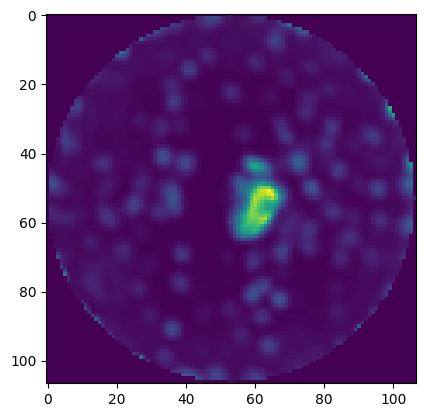

 11%|█████████████                                                                                                          | 11/100 [00:17<02:23,  1.61s/it]

0.34535330533981323


 12%|██████████████▎                                                                                                        | 12/100 [00:19<02:21,  1.61s/it]

0.3453541398048401


 13%|███████████████▍                                                                                                       | 13/100 [00:20<02:19,  1.60s/it]

0.34535548090934753


 14%|████████████████▋                                                                                                      | 14/100 [00:22<02:17,  1.60s/it]

0.34535640478134155


 15%|█████████████████▊                                                                                                     | 15/100 [00:24<02:15,  1.59s/it]

0.34535661339759827


 16%|███████████████████                                                                                                    | 16/100 [00:25<02:13,  1.59s/it]

0.3453560769557953


 17%|████████████████████▏                                                                                                  | 17/100 [00:27<02:12,  1.59s/it]

0.345355361700058


 18%|█████████████████████▍                                                                                                 | 18/100 [00:28<02:10,  1.59s/it]

0.34535467624664307


 19%|██████████████████████▌                                                                                                | 19/100 [00:30<02:08,  1.59s/it]

0.345353901386261
0.3453531563282013


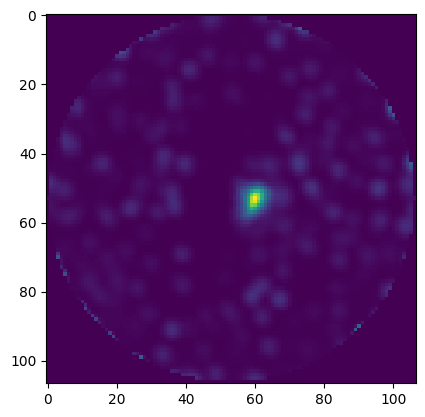

 21%|████████████████████████▉                                                                                              | 21/100 [00:33<02:07,  1.61s/it]

0.3453524112701416


 22%|██████████████████████████▏                                                                                            | 22/100 [00:35<02:05,  1.61s/it]

0.34535181522369385


 23%|███████████████████████████▎                                                                                           | 23/100 [00:36<02:03,  1.60s/it]

0.3453514873981476


 24%|████████████████████████████▌                                                                                          | 24/100 [00:38<02:01,  1.60s/it]

0.34535136818885803


 25%|█████████████████████████████▊                                                                                         | 25/100 [00:40<01:59,  1.60s/it]

0.34535133838653564


 26%|██████████████████████████████▉                                                                                        | 26/100 [00:41<01:58,  1.60s/it]

0.34535127878189087
0.34535133838653564


 28%|█████████████████████████████████▎                                                                                     | 28/100 [00:44<01:54,  1.59s/it]

0.3453514873981476


 29%|██████████████████████████████████▌                                                                                    | 29/100 [00:46<01:53,  1.59s/it]

0.3453517258167267
0.3453519344329834


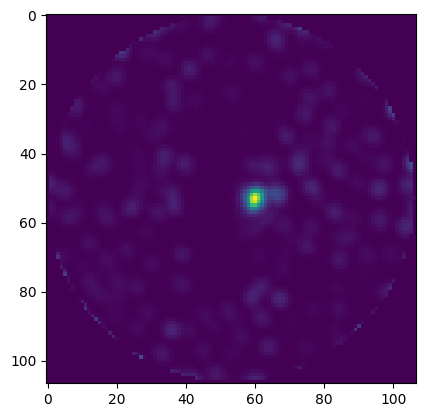

 31%|████████████████████████████████████▉                                                                                  | 31/100 [00:49<01:51,  1.62s/it]

0.3453521728515625


 32%|██████████████████████████████████████                                                                                 | 32/100 [00:51<01:49,  1.61s/it]

0.34535229206085205


 33%|███████████████████████████████████████▎                                                                               | 33/100 [00:52<01:47,  1.60s/it]

0.34535226225852966


 34%|████████████████████████████████████████▍                                                                              | 34/100 [00:54<01:45,  1.60s/it]

0.3453521430492401


 35%|█████████████████████████████████████████▋                                                                             | 35/100 [00:56<01:43,  1.59s/it]

0.3453519344329834


 36%|██████████████████████████████████████████▊                                                                            | 36/100 [00:57<01:41,  1.59s/it]

0.3453516364097595


 37%|████████████████████████████████████████████                                                                           | 37/100 [00:59<01:40,  1.59s/it]

0.3453513979911804


 38%|█████████████████████████████████████████████▏                                                                         | 38/100 [01:00<01:38,  1.59s/it]

0.3453511595726013


 39%|██████████████████████████████████████████████▍                                                                        | 39/100 [01:02<01:36,  1.59s/it]

0.3453510105609894
0.3453507721424103


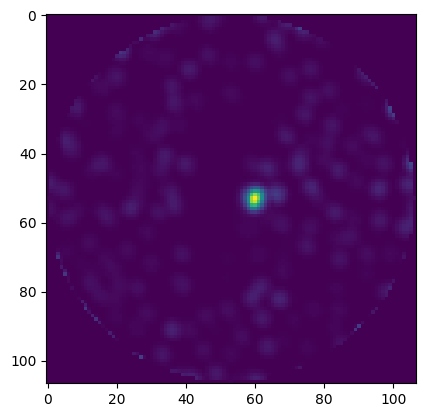

 41%|████████████████████████████████████████████████▊                                                                      | 41/100 [01:05<01:35,  1.61s/it]

0.34535059332847595


 42%|█████████████████████████████████████████████████▉                                                                     | 42/100 [01:07<01:33,  1.61s/it]

0.3453506827354431


 43%|███████████████████████████████████████████████████▏                                                                   | 43/100 [01:08<01:31,  1.60s/it]

0.3453506827354431


 44%|████████████████████████████████████████████████████▎                                                                  | 44/100 [01:10<01:29,  1.60s/it]

0.3453506827354431


 45%|█████████████████████████████████████████████████████▌                                                                 | 45/100 [01:12<01:27,  1.59s/it]

0.3453507721424103


 46%|██████████████████████████████████████████████████████▋                                                                | 46/100 [01:13<01:25,  1.59s/it]

0.34535083174705505


 47%|███████████████████████████████████████████████████████▉                                                               | 47/100 [01:15<01:24,  1.59s/it]

0.34535083174705505


 48%|█████████████████████████████████████████████████████████                                                              | 48/100 [01:16<01:22,  1.59s/it]

0.34535083174705505


 49%|██████████████████████████████████████████████████████████▎                                                            | 49/100 [01:18<01:21,  1.59s/it]

0.3453509211540222
0.3453509211540222


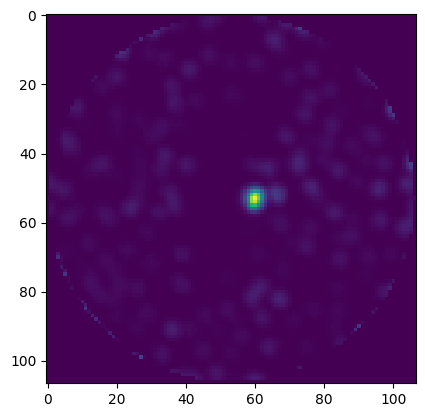

 51%|████████████████████████████████████████████████████████████▋                                                          | 51/100 [01:21<01:19,  1.61s/it]

0.34535083174705505


 52%|█████████████████████████████████████████████████████████████▉                                                         | 52/100 [01:23<01:17,  1.61s/it]

0.34535059332847595


 53%|███████████████████████████████████████████████████████████████                                                        | 53/100 [01:24<01:15,  1.60s/it]

0.3453505337238312


 54%|████████████████████████████████████████████████████████████████▎                                                      | 54/100 [01:26<01:13,  1.60s/it]

0.345350444316864


 55%|█████████████████████████████████████████████████████████████████▍                                                     | 55/100 [01:28<01:11,  1.59s/it]

0.3453504145145416


 56%|██████████████████████████████████████████████████████████████████▋                                                    | 56/100 [01:29<01:10,  1.59s/it]

0.34535035490989685


 57%|███████████████████████████████████████████████████████████████████▊                                                   | 57/100 [01:31<01:08,  1.59s/it]

0.34535032510757446


 58%|█████████████████████████████████████████████████████████████████████                                                  | 58/100 [01:32<01:06,  1.59s/it]

0.3453502357006073


 59%|██████████████████████████████████████████████████████████████████████▏                                                | 59/100 [01:34<01:05,  1.59s/it]

0.3453502953052521
0.3453502953052521


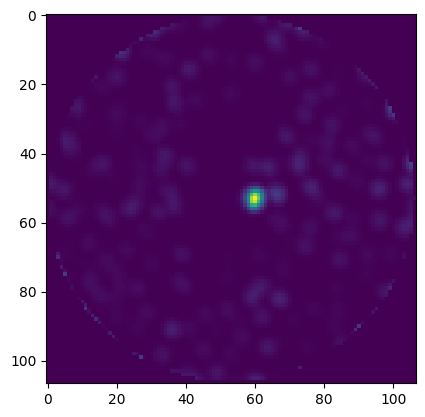

 61%|████████████████████████████████████████████████████████████████████████▌                                              | 61/100 [01:37<01:02,  1.61s/it]

0.3453502953052521


 62%|█████████████████████████████████████████████████████████████████████████▊                                             | 62/100 [01:39<01:01,  1.61s/it]

0.3453502953052521


 63%|██████████████████████████████████████████████████████████████████████████▉                                            | 63/100 [01:40<00:59,  1.60s/it]

0.3453502953052521


 64%|████████████████████████████████████████████████████████████████████████████▏                                          | 64/100 [01:42<00:57,  1.60s/it]

0.3453502953052521


 65%|█████████████████████████████████████████████████████████████████████████████▎                                         | 65/100 [01:44<00:55,  1.59s/it]

0.34535035490989685


 66%|██████████████████████████████████████████████████████████████████████████████▌                                        | 66/100 [01:45<00:54,  1.59s/it]

0.3453502953052521


 67%|███████████████████████████████████████████████████████████████████████████████▋                                       | 67/100 [01:47<00:52,  1.59s/it]

0.3453502058982849


 68%|████████████████████████████████████████████████████████████████████████████████▉                                      | 68/100 [01:48<00:50,  1.59s/it]

0.3453502058982849


 69%|██████████████████████████████████████████████████████████████████████████████████                                     | 69/100 [01:50<00:49,  1.59s/it]

0.34535011649131775
0.34535008668899536


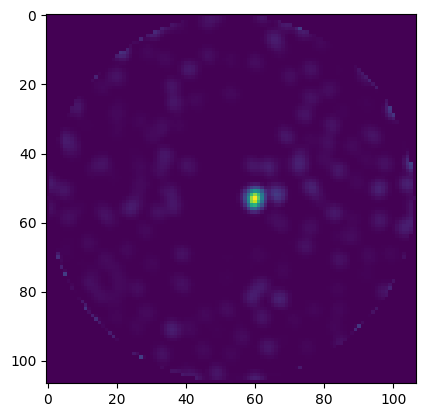

 71%|████████████████████████████████████████████████████████████████████████████████████▍                                  | 71/100 [01:53<00:46,  1.61s/it]

0.3453500270843506


 72%|█████████████████████████████████████████████████████████████████████████████████████▋                                 | 72/100 [01:55<00:44,  1.60s/it]

0.3453500270843506


 73%|██████████████████████████████████████████████████████████████████████████████████████▊                                | 73/100 [01:56<00:43,  1.60s/it]

0.3453500270843506


 74%|████████████████████████████████████████████████████████████████████████████████████████                               | 74/100 [01:58<00:41,  1.60s/it]

0.3453500270843506


 75%|█████████████████████████████████████████████████████████████████████████████████████████▎                             | 75/100 [02:00<00:39,  1.60s/it]

0.3453500270843506


 76%|██████████████████████████████████████████████████████████████████████████████████████████▍                            | 76/100 [02:01<00:38,  1.59s/it]

0.34535008668899536


 77%|███████████████████████████████████████████████████████████████████████████████████████████▋                           | 77/100 [02:03<00:36,  1.59s/it]

0.34535008668899536


 78%|████████████████████████████████████████████████████████████████████████████████████████████▊                          | 78/100 [02:04<00:35,  1.59s/it]

0.34535011649131775


 79%|██████████████████████████████████████████████████████████████████████████████████████████████                         | 79/100 [02:06<00:33,  1.59s/it]

0.34535011649131775
0.3453500270843506


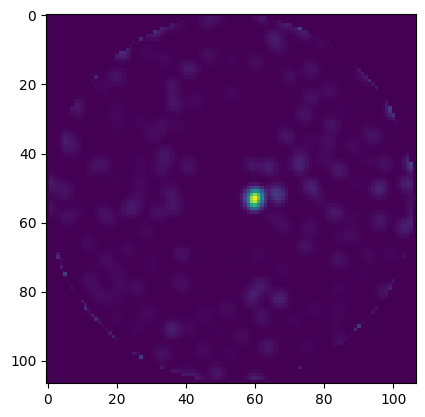

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 81/100 [02:09<00:30,  1.61s/it]

0.3453500270843506


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 82/100 [02:11<00:28,  1.60s/it]

0.3453500270843506


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 83/100 [02:12<00:27,  1.60s/it]

0.3453500270843506


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 84/100 [02:14<00:25,  1.60s/it]

0.3453499674797058


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 85/100 [02:16<00:23,  1.59s/it]

0.3453500270843506


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 86/100 [02:17<00:22,  1.59s/it]

0.34535008668899536


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 87/100 [02:19<00:20,  1.59s/it]

0.3453500270843506


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 88/100 [02:20<00:19,  1.59s/it]

0.3453499972820282


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 89/100 [02:22<00:17,  1.59s/it]

0.3453500270843506
0.34535008668899536


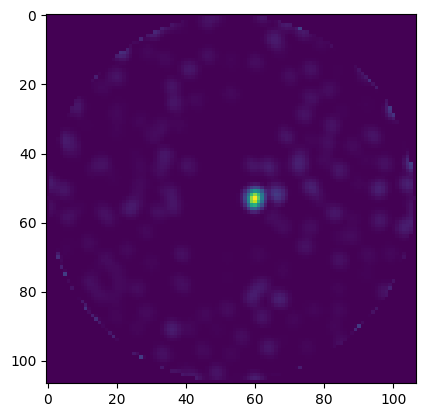

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 91/100 [02:25<00:14,  1.61s/it]

0.34535011649131775


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 92/100 [02:27<00:12,  1.61s/it]

0.34535011649131775


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 93/100 [02:28<00:11,  1.60s/it]

0.3453500270843506


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 94/100 [02:30<00:09,  1.60s/it]

0.3453500270843506


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 95/100 [02:32<00:07,  1.59s/it]

0.3453500270843506


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 96/100 [02:33<00:06,  1.59s/it]

0.3453500270843506


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 97/100 [02:35<00:04,  1.59s/it]

0.3453500270843506


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 98/100 [02:36<00:03,  1.59s/it]

0.3453500270843506


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 99/100 [02:38<00:01,  1.59s/it]

0.3453499674797058
0.3453499674797058


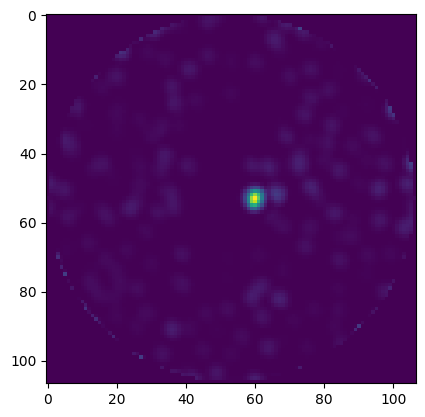

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


In [112]:
losses_recon = []
losses_reg = []

for epoch in tqdm(range(100)):
    optimizer.zero_grad(set_to_none=True)
    
    # 1.) Get the current planet signal estimate
    planet_signal = s4_planet_model.forward(test_idx)
    
    # 2.) Get the current data without the planet
    data_no_planet = science_data_X - planet_signal.squeeze().detach()
    
    # 3.) Setup the normalization
    X_mu = torch.mean(data_no_planet, axis=0)
    X_std = torch.std(data_no_planet, axis=0)
    
    # 3.) Setup the normalization
    #X_mu = s4_noise.mean_frame
    #X_std = s4_noise.std_frame
    
    # 4.) get the current normalized data
    X_norm = (science_data_X - X_mu) / X_std
    planet_signal_norm = planet_signal / X_std
    
    # 5.) reshape everything 
    planet_signal_norm = planet_signal_norm.view(
        science_data_X.shape[0], -1)
    science_norm_flatten = X_norm.view(
        X_norm.shape[0], -1)
    
    # 6.) run the forward path
    P_hat_N = s4_noise(planet_signal_norm)
    P_hat_N[P_hat_N>0] = 0
    
    noise_estimate = s4_noise(science_norm_flatten) - P_hat_N

    # 7.) estimate the modeled data
    modeled_data = noise_estimate + planet_signal_norm
    
    # 8.) Compute the loss       
    loss_recon = ((modeled_data - science_norm_flatten)**2).mean()
    #loss_reg = (s4_noise.betas_raw**2).mean()

    # 9.) Backward 
    loss = loss_recon # + loss_reg * s4_noise.lambda_reg
    loss.backward()

    optimizer.step()

    # 10.) Print the loss terms
    losses_recon.append(loss_recon.item())
    print(loss_recon.item())
    
    if epoch % 10 == 9:
        # plot the planet signal
        with torch.no_grad():
            tmp_norm_signal = s4_planet_model.get_planet_signal() / X_std.detach()
            plt.imshow(tmp_norm_signal.cpu().numpy()[0])
            plt.show()

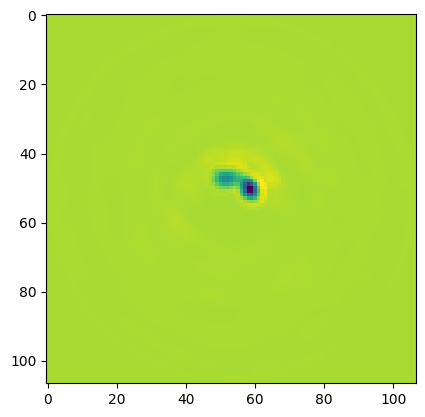

In [113]:
plt.imshow(s4_noise.mean_frame.cpu() - X_mu.cpu())

In [122]:
# 1.) Get the current planet signal estimate
planet_signal = s4_planet_model.forward(test_idx)

# 2.) Get the current data without the planet
data_no_planet = science_data_X - planet_signal.squeeze().detach()

# 3.) Setup the normalization
X_mu = torch.mean(data_no_planet, axis=0)
X_std = torch.std(data_no_planet, axis=0)

# 3.) Setup the normalization
#X_mu = s4_noise.mean_frame
#X_std = s4_noise.std_frame

# 4.) get the current normalized data
X_norm = (science_data_X - X_mu) / X_std
X_no_planet = (science_data_X - planet_signal.squeeze() - X_mu) / X_std
    
# 5.) reshape everything 
science_norm_flatten = X_norm.view(
    X_norm.shape[0], -1)

science_norm_flatten_no_planet = X_no_planet.view(
    X_norm.shape[0], -1)

noise_estimate = s4_noise(science_norm_flatten_no_planet)

In [123]:
# compute the residual
residuals = science_norm_flatten - noise_estimate
residual_stack = residuals.view(
    science_data_X.shape[0], 
    s4_noise.image_size,
    s4_noise.image_size).detach().cpu().numpy()

In [124]:
residuals_unbiased = science_norm_flatten_no_planet - noise_estimate
residuals_unbiased = residuals_unbiased.view(
    science_data_X.shape[0], 
    s4_noise.image_size,
    s4_noise.image_size).detach().cpu().numpy()

unbiased_median_frame = np.median(residual_stack_unbiased, axis=0)

In [130]:
unbiased_median_frame = np.median(residual_stack, axis=0)

In [131]:
residual_stack = residual_stack - unbiased_median_frame

results = combine_residual_stack(
    residual_stack=residual_stack,
    angles=anlges_train,
    combine=["Median_Residuals",],
    suffix="",
    num_cpus=8)

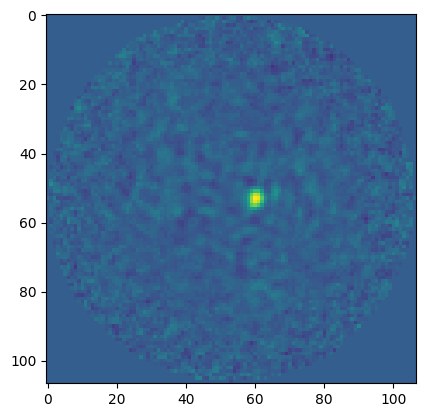

In [129]:
# residual on training data
plt.imshow(results["Median_Residuals"],
           vmin=-0.03, vmax=0.07)

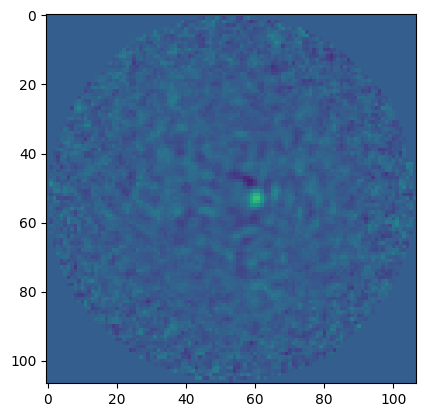

In [134]:
# residual on training data
plt.imshow(results["Median_Residuals"],
           vmin=-0.03, vmax=0.07)